# Using PLAYA-PDF to extract links

PDFs can contain a bewilderingly large variety of annotations, the most interesting and useful of which are `Link` annotations.  These create areas on the page which, when clicked, can cause a PDF reader to jump to a destination in the same document, open an external URL in a browser, or possibly other actions.

Here we will look at a document (again, a research paper) with a lot of internal links, and build a graph of the links between pages, which we can visualize with `graphviz`.  We'll also find the *external* links and output them as a list of HTML with their associated text.

As usual let's import some basic stuff:

In [1]:
import playa
import paves.image as pi
import graphviz

And load a document:

In [2]:
DOCUMENT = "../samples/contrib/stochastic_parrots.pdf"
pdf = playa.open(DOCUMENT)

## Graph of internal links

Now let's make a `graphviz` graph that just contains edges from the page containing each link to the page of its destination.  As you can see, getting the destination from a link is not entirely straightforward at the moment.  This will be improved in a subsequent version of PLAYA:

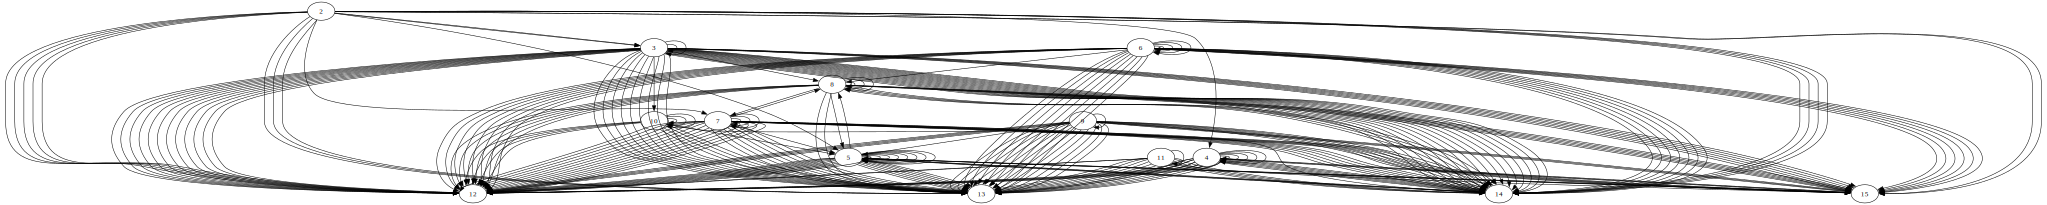

In [12]:
dot = graphviz.Digraph("links")
for page in pdf.pages:
    for annot in page.annotations:
        dest = None
        if annot.type == "Link":
            if "D" in annot.props:
                dest = playa.Destination.from_dest(annot.props["D"], pdf)
            if "A" in annot.props:
                action = playa.Action.from_dict(annot.props["A"], pdf)
                if action.props["S"].name == "GoTo":
                    dest = playa.Destination.from_dest(action.props["D"], pdf)
        if dest is not None:
            dot.edge(str(page.label), str(dest.page.label))
dot

Well, that definitely looks like a research paper, with most of the links pointing to the bibliography!

## Finding external links

What about external links?  There are a few of these, which can be detected because they contain a `/URI` action.  Let's look at a few of them on a page:

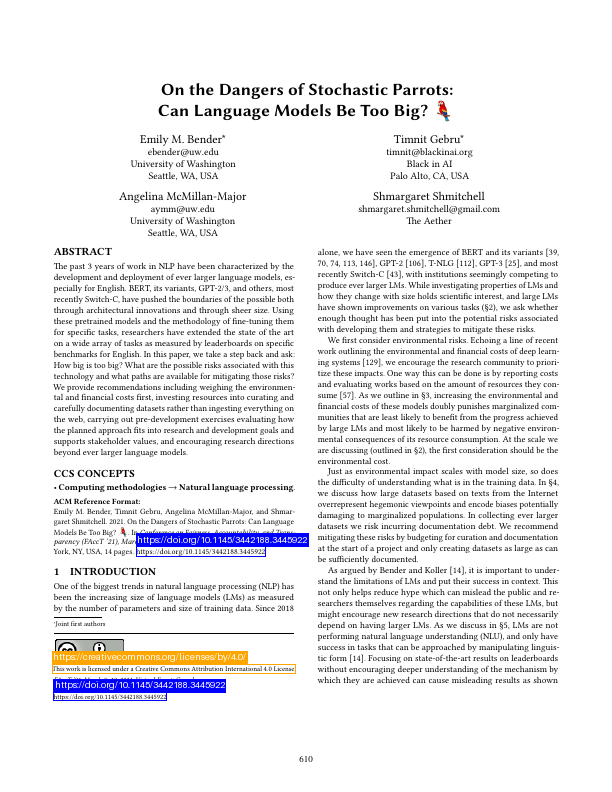

In [25]:
page = pdf.pages[1]
def is_external_link(annot):
    if annot.type == "Link" and "A" in annot.props:
        action = playa.Action.from_dict(annot.props["A"], pdf)
        return action.props["S"].name == "URI"
    return False
pi.box([annot for annot in page.annotations if is_external_link(annot)],
       labelfunc=lambda annot: playa.resolve(annot.props["A"])["URI"].decode('ascii'))

We can, of course, also extract the text covered by the link's rectangle using `extract_text`, though this isn't a particularly efficient or precise (for reasons noted in the documentation) way to do this:

In [30]:
for annot in page.annotations:
    if annot.type == "Link" and "A" in annot.props:
        action = playa.Action.from_dict(annot.props["A"], pdf)
        if action.props["S"].name == "URI":
            print(action.props["URI"], page.extract_text(bbox=annot.bbox))

b'https://doi.org/10.1145/3442188.3445922' https://doi.org/10.1145/3442188.3445922
b'https://doi.org/10.1145/3442188.3445922' https://doi.org/10.1145/3442188.3445922 
b'https://creativecommons.org/licenses/by/4.0/' This work is licensed under a Creative Commons Attribution International 4.0 License.
